# NVIDIA Stock Price Prediction using ML

I am going to try and predict the future value of Nvidia company stock. I will use a LSTM network to predict the closing stock price using the past stock price. The machine learning technique called Long Short Term Memory is an artificial recurrent neural network architecture used in the field of deep learning.

In [1]:
import os
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.preprocessing import MinMaxScaler

## Data Acquisition and Preperation

For the project we will be downloading real time data from Yahoo Finance, ussing the yfinance module. We'll use data for a single stock (Nvidia) from when it started trading to the present. You can replace this with any stock. 

Column listed:
- Date ad Time – Format of date is: “yy-mm-dd” then time
- Open – Price of the stock at open of the market
- High – Highest price reached during the day
- Low – Lowest price reached during the day
- Close – Price of the stock at the close of the market
- Volume – Number of shares traded that day
- Divedends and Stock Splits wil not be used 

In [2]:
NVDA = yf.Ticker('NVDA')
NVDA_hist = NVDA.history(period='max')

In [3]:
DATA_PATH = 'NVDA_data.csv'

if os.path.exists(DATA_PATH):
    with open(DATA_PATH) as f:
        NVDA.history = pd.read_csv(DATA_PATH)
else:
    NVDA = yf.Ticker('NVDA')
    NVDA.history = NVDA.history(period='max')

    NVDA.history.to_csv(DATA_PATH)

In [4]:
NVDA.history.head(10)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1999-01-22 00:00:00-05:00,0.401374,0.447962,0.355980,0.376288,271468800,0.0,0.0
1,1999-01-25 00:00:00-05:00,0.406152,0.420487,0.376288,0.415709,51048000,0.0,0.0
2,1999-01-26 00:00:00-05:00,0.420487,0.428849,0.377482,0.383456,34320000,0.0,0.0
3,1999-01-27 00:00:00-05:00,0.384650,0.394207,0.363147,0.382261,24436800,0.0,0.0
4,1999-01-28 00:00:00-05:00,0.382261,0.384650,0.378677,0.381067,22752000,0.0,0.0
5,1999-01-29 00:00:00-05:00,0.381067,0.382261,0.363147,0.363147,24403200,0.0,0.0
6,1999-02-01 00:00:00-05:00,0.363147,0.372704,0.363147,0.370315,15470400,0.0,0.0
7,1999-02-02 00:00:00-05:00,0.363147,0.372704,0.330894,0.341646,26409600,0.0,0.0
8,1999-02-03 00:00:00-05:00,0.336868,0.353591,0.334478,0.348813,7512000,0.0,0.0
9,1999-02-04 00:00:00-05:00,0.353592,0.377482,0.348813,0.367926,18192000,0.0,0.0


<Axes: >

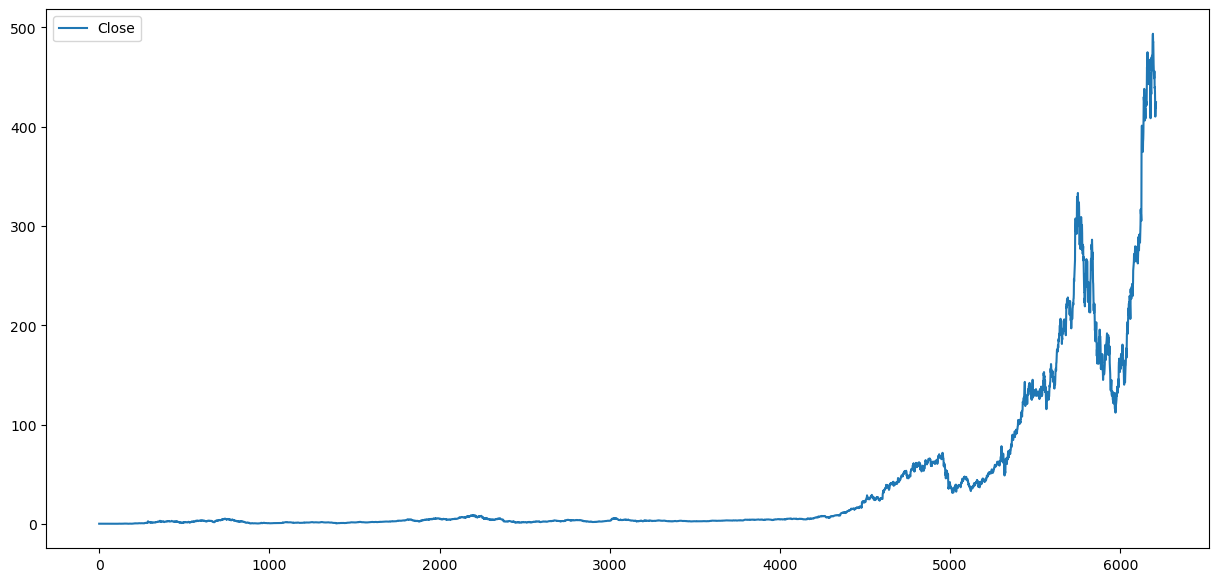

In [5]:
fig_size = (15, 7)

NVDA.history.plot.line(y="Close", use_index=True, figsize=fig_size)

<Axes: >

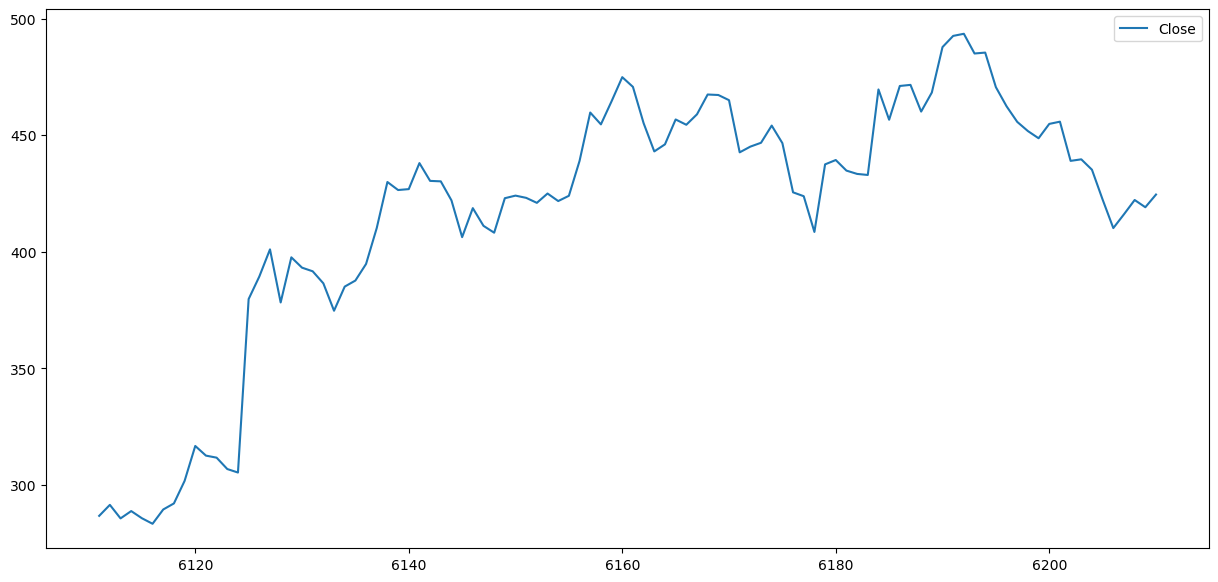

In [6]:
fig_size = (15, 7)

NVDA.history.tail(100).plot.line(y="Close", use_index=True, figsize=fig_size)

## Creating a new Dataframe and Training data

We will only be consider the closing market price and predicting the closing market price.

Create a data set to train the data that contains the closing price of 160 days so that we could do the prediction for the 161st closing price. (The days can to reduce error, for me 160 gave the lowest error so it was choosen. With more testing a more suitable number can be found). 

In [12]:
close_NVDA_data = NVDA.history.filter(['Close'])
 
dataset = close_NVDA_data.values
 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
 
training_data_len = math.ceil(len(dataset) *.80)
train_data = scaled_data[0:training_data_len  , : ]
 
x_train_data=[]
y_train_data =[]
for i in range(160,len(train_data)):
    x_train_data=list(x_train_data)
    y_train_data=list(y_train_data)
    x_train_data.append(train_data[i-160:i,0])
    y_train_data.append(train_data[i,0])
    x_train_data1, y_train_data1 = np.array(x_train_data), np.array(y_train_data)
    x_train_data2 = np.reshape(x_train_data1, (x_train_data1.shape[0],x_train_data1.shape[1],1))

## Building LSTM Model and Compiling the Model

LSTM model will have two LSTM layers with 200 neurons and two Dense layers, two with 100 neurons and the other with one neuron. Once again again these can be changes to reduce error, but directly reelate to running time. If increased running time will increase. Batch size and epochs can also be increased but will effect running time. 

In [21]:
model = Sequential()
model.add(LSTM(units=200, return_sequences=True,input_shape=(x_train_data2.shape[1],1)))
model.add(LSTM(units=200, return_sequences=False))
model.add(Dense(units=100))
model.add(Dense(units=100))
model.add(Dense(units=1))

In [36]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train_data2, y_train_data1, batch_size=10, epochs=1)

481/481 [==============================] - 54s 107ms/step - loss: 1.2399e-05


## Testing the model on testing data



In [37]:
test_data = scaled_data[training_data_len - 160: , : ]
x_test = []
y_test =  dataset[training_data_len : , : ]
for i in range(160,len(test_data)):
    x_test.append(test_data[i-160:i,0])
 
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

39/39 [==============================] - 3s 57ms/step


### Error Calculation

RMSE is the root mean squared error, which helps to measure the accuracy of the model.
I recieved 11 which I is relatively high from what I have read online. But this was the lowest I can get it without further testing. With more testing a lower RMSE can be achieved. 


In [69]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print(rmse)

11.106805517355967


C:\Users\patel\AppData\Local\Temp\ipykernel_1372\3918704649.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v_1['Predictions'] = predictions


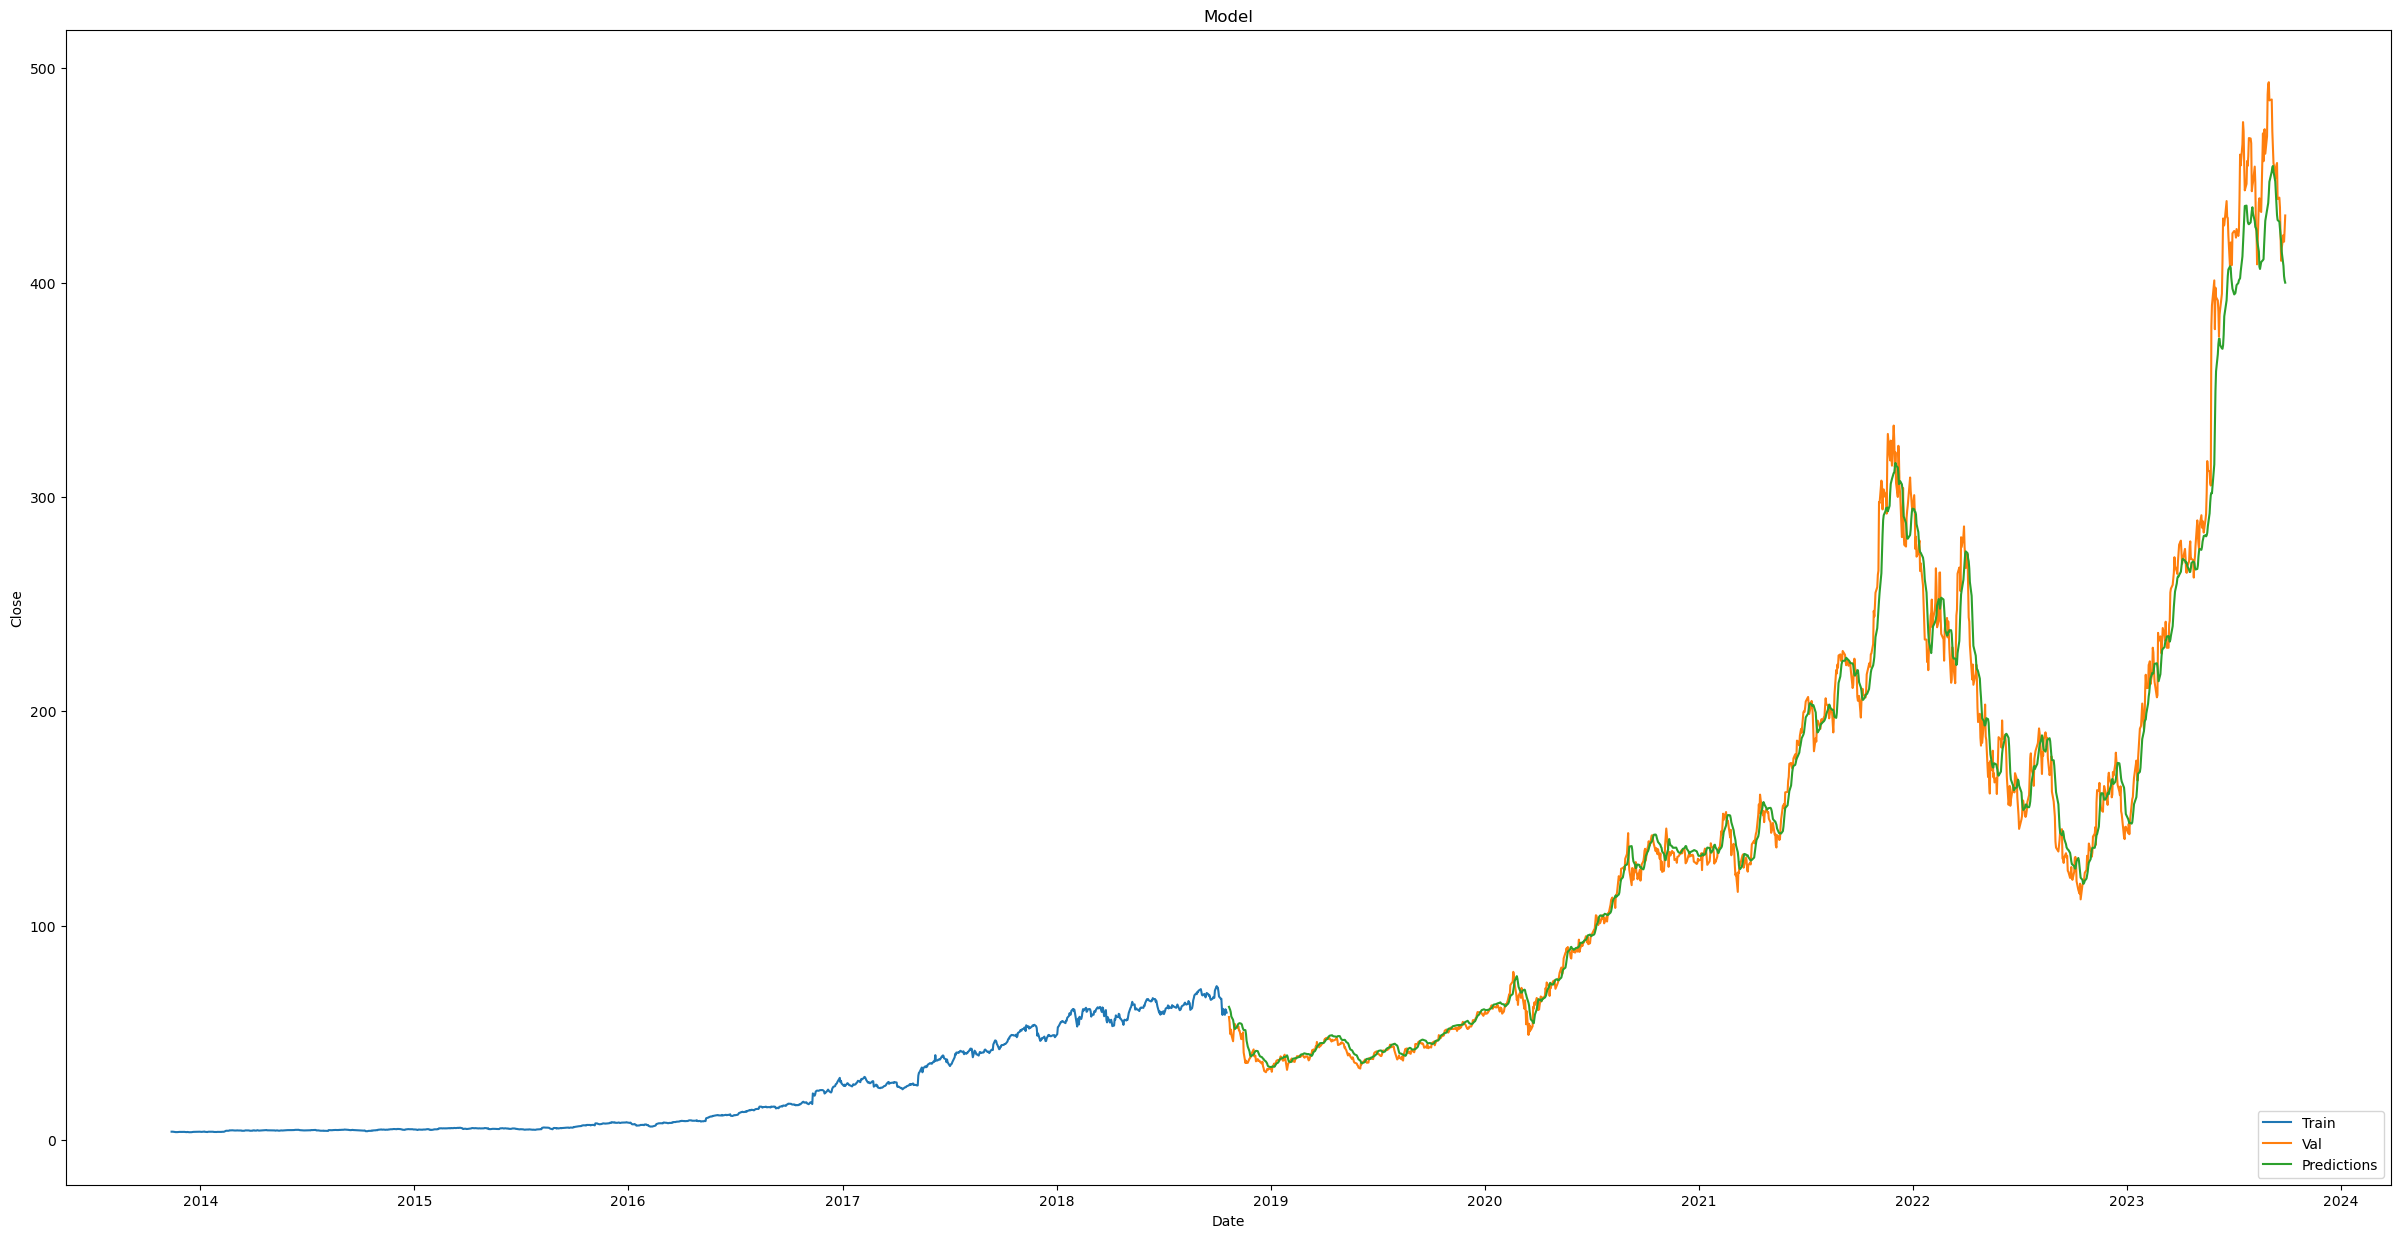

In [70]:
train = NVDA_hist[:training_data_len]
t_1 = train[-1242:]

valid = NVDA_hist[training_data_len:]
v_1 = valid[-1242:]

v_1['Predictions'] = predictions

fig_width = 30  
fig_height = 15
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close')
 
plt.plot(t_1['Close'])
plt.plot(v_1[['Close', 'Predictions']])
 
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
 
plt.show()

In [68]:
merged_df = pd.merge(NVDA_hist.tail(1242), v_1[['Predictions']], on='Date', how='inner')

merged_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Predictions
Date,,,,,,,,
2018-10-22 00:00:00-04:00,57.318573,58.319816,56.275202,57.303703,36884400,0.0,0.0,62.049953
2018-10-23 00:00:00-04:00,54.629593,55.561444,53.707662,54.785728,62643600,0.0,0.0,61.309998
2018-10-24 00:00:00-04:00,54.401594,54.867519,49.281388,49.420174,88428800,0.0,0.0,60.635544
2018-10-25 00:00:00-04:00,48.443715,51.982756,48.000094,51.509396,95172000,0.0,0.0,59.605122
2018-10-26 00:00:00-04:00,49.147559,50.765901,47.861310,49.142601,66478400,0.0,0.0,57.551029
...,...,...,...,...,...,...,...,...
2023-09-22 00:00:00-04:00,415.720001,421.149994,412.309998,416.100006,47817500,0.0,0.0,414.387207
2023-09-25 00:00:00-04:00,415.910004,425.359985,411.769989,422.220001,41909100,0.0,0.0,407.800446
2023-09-26 00:00:00-04:00,420.010010,428.200012,416.549988,419.109985,40228200,0.0,0.0,403.050140


In [66]:
merged_df[['Close', 'Predictions']]

,Close,Predictions
Date,,
2018-10-22 00:00:00-04:00,57.303703,62.049953
2018-10-23 00:00:00-04:00,54.785728,61.309998
2018-10-24 00:00:00-04:00,49.420174,60.635544
2018-10-25 00:00:00-04:00,51.509396,59.605122
2018-10-26 00:00:00-04:00,49.142601,57.551029
...,...,...
2023-09-22 00:00:00-04:00,416.100006,414.387207
2023-09-25 00:00:00-04:00,422.220001,407.800446
2023-09-26 00:00:00-04:00,419.109985,403.050140


### Improvements

Improve the algorithm:
- Decrease RMSE by doing more testing. Changing test data size, increasing step size. Testing different bins and epochs. Aslo adding more layers (aswell as dense layers).

Add in more predictors:
- Early trading/Trading on other exchanges (gives insight to global sentiment).

Economic indicators:
- Use both open and close price in predictions.
- Include Volume in predictions. 
- Interest rates.

Use different algorithm:
- Try something different like an Echo State Network or Random Forest. 